# PSF photometry on artificial Gaussian stars

This notebook demonstrates artificial PSF photometry on simple "stars" made from Gaussian function.

This notebook requires Python 3.x, Astropy v1.1 or greater, and matplotlib v1.5 or greater 

In [1]:
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting

In [2]:
import photutils
from photutils import psf

photutils.__version__

'0.3.dev1715'

In [3]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (15,10)
rcParams['image.interpolation'] = 'none'

## First lets experiment with fake image of a single star with Gaussian PSF

In [4]:
gmod = models.Gaussian2D(x_stddev=5, y_stddev=5)

((-27.5, 27.5), (-27.5, 27.5))

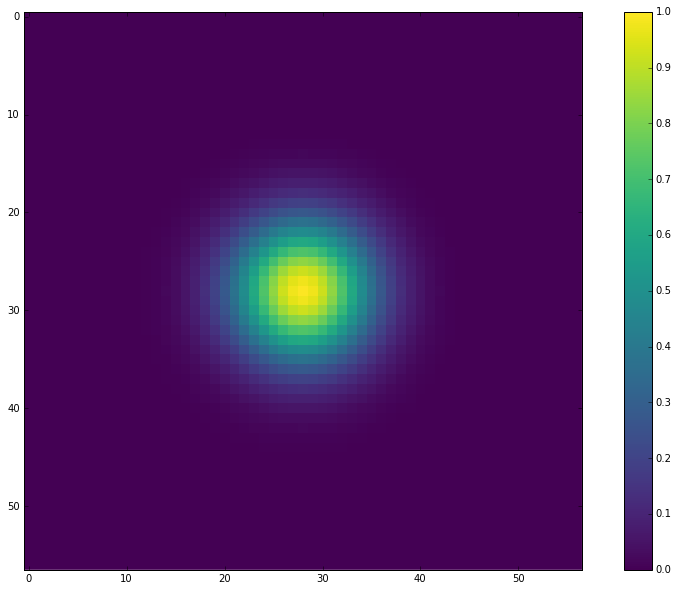

In [5]:
#without arguments, `render` creates an image based on the bounding_box, which defaults to 5.5 sigma
plt.imshow(gmod.render(), vmin=0, vmax=1)
plt.colorbar()
gmod.bounding_box

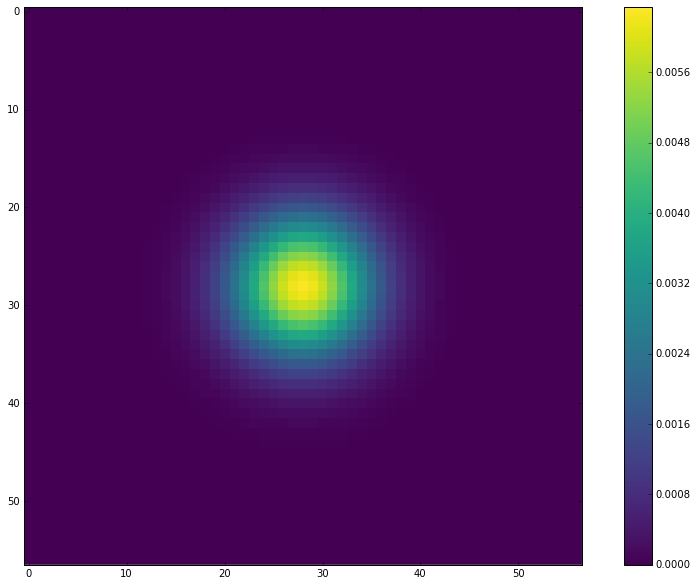

In [6]:
# this is a subtly different Gaussian that is integrated over pixels
gmodi = psf.IntegratedGaussianPRF(sigma=5)

# make it match the above plot
gmodi.bounding_box = gmod.bounding_box

plt.imshow(gmodi.render())
plt.colorbar()

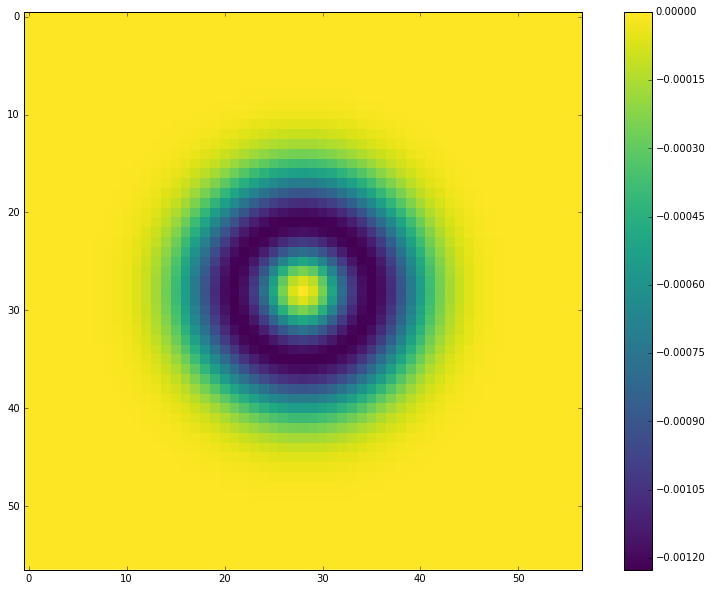

In [7]:
# also compare the IntegratedGaussianPRF to the Gaussian2DModel.  Note that we need to re-scale the flux to match the Gaussian2D
plt.imshow(gmod.render() - gmodi.render()/gmodi.render().max())
plt.colorbar()

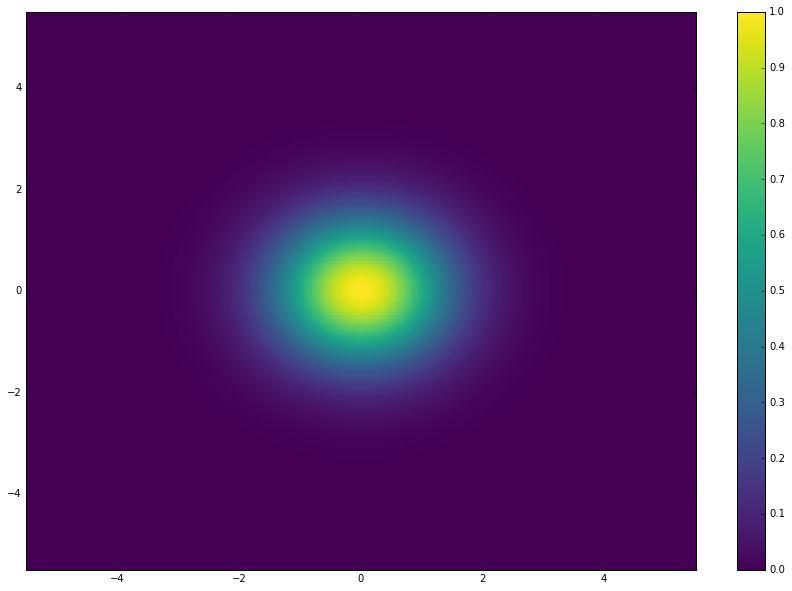

In [8]:
# To render into a specific set of x/y coordinates, 
# pass that into the `coords`  argument of `render
coo = np.mgrid[-5.5:5.5:256j, -5.5:5.5:256j]

gmod.x_stddev = gmod.y_stddev = 1
gmod.bounding_box = None

plt.pcolor(*coo, gmod.render(coords=coo), vmin=0, vmax=1)
plt.xlim(-5.5,5.5)
plt.ylim(-5.5,5.5)
plt.colorbar()

## Now create an image that's got a few stars

In [9]:
nstars = 20
imgshape = (256, 256)
poisson_scale = 15
bkg = 1
flux_scale = 1000




np.random.seed(12345)

xs, ys = np.random.rand(2, nstars)*204 + 18 # centers should be at least 3sig from the edge
fluxes = (np.random.rand(nstars)+.5)*flux_scale

0.0666666666667 8.69072054059 9.8


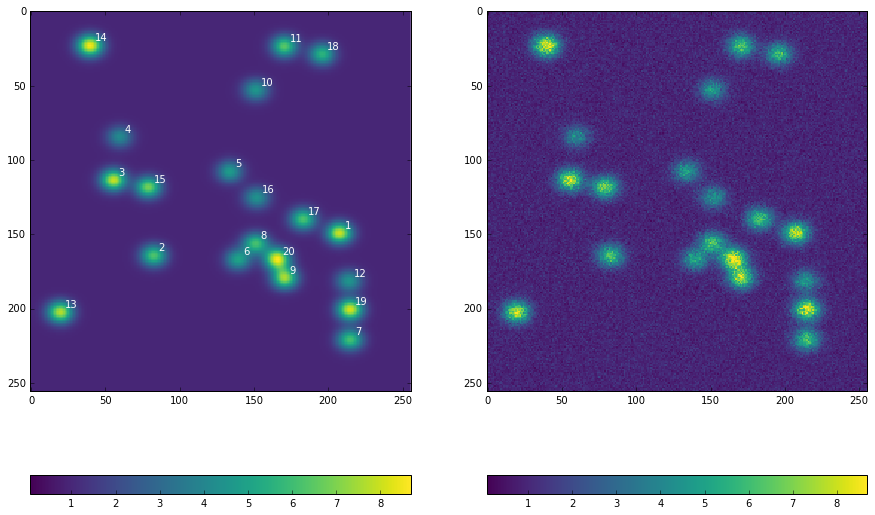

In [10]:
gmod_star = models.Gaussian2D(x_stddev=6, y_stddev=5)

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

# perfect flux image with slightly elliptical PSF
im = np.ones(imgshape)*bkg

for row in intab:
    del gmod_star.bounding_box  # resets the bounding box to the default
    gmod_star.x_mean = row['x_0']
    gmod_star.y_mean = row['y_0']
    gmod_star.amplitude = row['flux_0']/(2*np.pi*gmod_star.x_stddev*gmod_star.y_stddev)
    gmod_star.render(im)
    
# poisson-ified image with slightly elliptical PSF
pim = np.random.poisson(poisson_scale*im)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(im, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')
for i, row in enumerate(intab):
    plt.annotate(str(i+1), (row['x_0'], row['y_0']), 
                 (5, 5), textcoords='offset points', 
                 color='w')

plt.subplot(1,2,2)
plt.imshow(pim, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

print(np.min(pim), np.max(im), np.max(pim))

0.0666666666667 8.69072054059 10.2


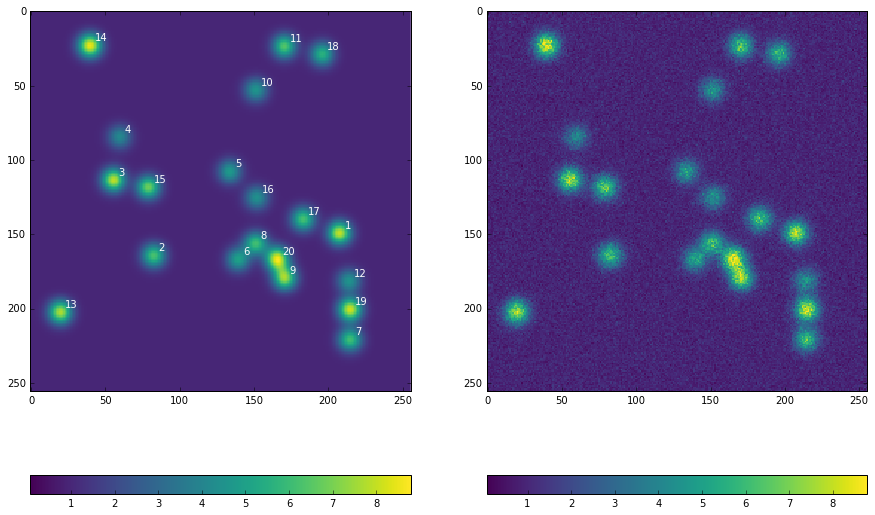

In [11]:
round_sigma = (gmod_star.x_stddev*gmod_star.y_stddev)**0.5

gmodi_star = psf.IntegratedGaussianPRF(sigma=round_sigma)

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

# perfect flux image with round IntegratedGaussianPRF
imi = np.ones(imgshape)*bkg

for row in intab:
    del gmodi_star.bounding_box  # resets the bounding box to the default
    gmodi_star.x_0 = row['x_0']
    gmodi_star.y_0 = row['y_0']
    gmodi_star.flux = row['flux_0']
    gmodi_star.render(imi)
    
# poisson-ified image with round IntegratedGaussianPRF
pimi = np.random.poisson(poisson_scale*imi)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(imi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')
for i, row in enumerate(intab):
    plt.annotate(str(i+1), (row['x_0'], row['y_0']), 
                 (5, 5), textcoords='offset points', 
                 color='w')

plt.subplot(1,2,2)
plt.imshow(pimi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

print(np.min(pimi), np.max(im), np.max(pimi))

# Some utility functions used for plotting below 

In [12]:
def residuals_psf_sub_table(outtab, title=None):
    plt.subplot(3,1,1)
    if title is not None:
        plt.title(title)
    plt.scatter(np.arange(len(outtab))+1, (outtab['flux_fit']-outtab['flux_0'])*100./outtab['flux_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('fluxperc')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,2)
    plt.scatter(np.arange(len(outtab))+1, outtab['x_fit']-outtab['x_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dx')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,3)
    plt.scatter(np.arange(len(outtab))+1, outtab['y_fit']-outtab['y_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dy')
    plt.xlim(0.5, len(outtab)+.5)
    
    plt.tight_layout()

In [13]:
# note that this assumes the underlying image is the same as the above
def compare_psf_sub(subim, pim, im, kw1s={}, kw2s={}, kw3s={}, kw4s={}):
    subps = (2, 2)
    cborient = 'vertical'
    
    plt.subplot(*subps,1)
    plt.imshow(pim, **kw1s)
    plt.colorbar(orientation=cborient)
    plt.title('Base image')

    plt.subplot(*subps,2)
    plt.imshow(subim, **kw2s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF subtracted image')
    print("Subtracted image bkg-sub mean:", np.mean(subim-bkg), 'and SD:', np.std(subim-bkg))

    plt.subplot(*subps,3)
    plt.imshow(im, **kw3s)
    plt.colorbar(orientation=cborient)
    plt.title('Real noise-free images')

    plt.subplot(*subps,4)
    plt.imshow(pim-subim, **kw4s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF images')

# Now do the actual PSF fitting and subtraction

In [14]:
psf_guess = psf.IntegratedGaussianPRF(flux=1, sigma=round_sigma)
psf_guess.flux.fixed = psf_guess.x_0.fixed = psf_guess.y_0.fixed = False
psf_guess.x_0.sigma = True

### Start with perfect inputs 

Assuming you know the flux and locations perfectly, how well can you subtract?

Subtracted image bkg-sub mean: -0.00183316122281 and SD: 0.296459071302


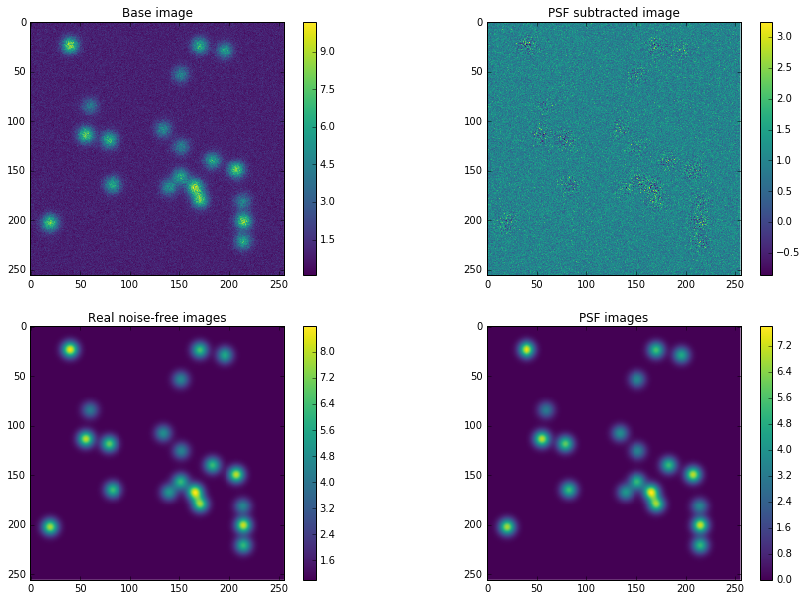

In [15]:
subimi = psf.subtract_psf(pimi, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subimi, pimi, imi)

Now what about when the PSF doesn't quite match? (The image was generated with a slightly elliptical PSF)

Subtracted image bkg-sub mean: 0.000168791902188 and SD: 0.310132552083


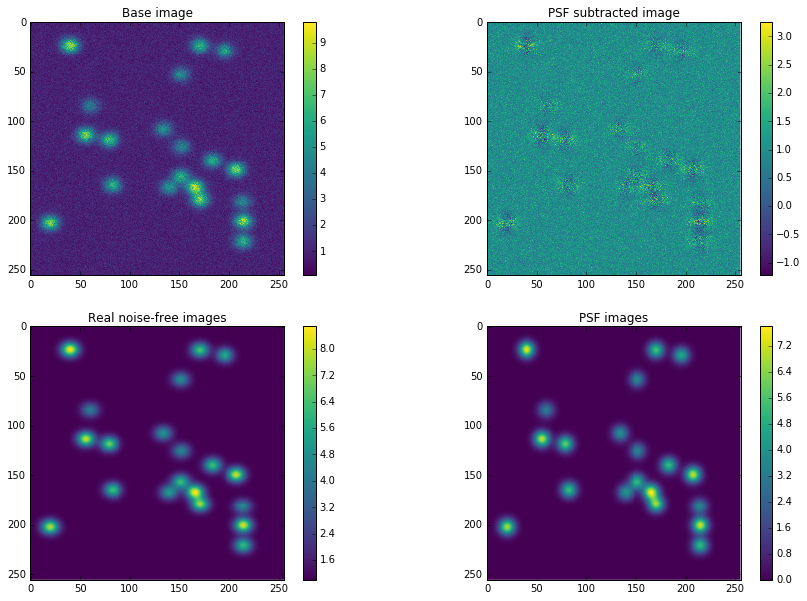

In [16]:
subim = psf.subtract_psf(pim, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subim, pim, im)

In [17]:
# fitting region used by all the below 
fitshape = (8,8)

## Now try actually *fitting* the target stars

### Perfect info on location/flux

Start with perfect initial gluesses for the flux and location, starting with a perfect PSF model 

In [18]:
# with integrated psf
outtabi = psf.psf_photometry(pimi - bkg, intab, psf_guess, fitshape)
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: -0.00586806386153 and SD: 0.307770131926


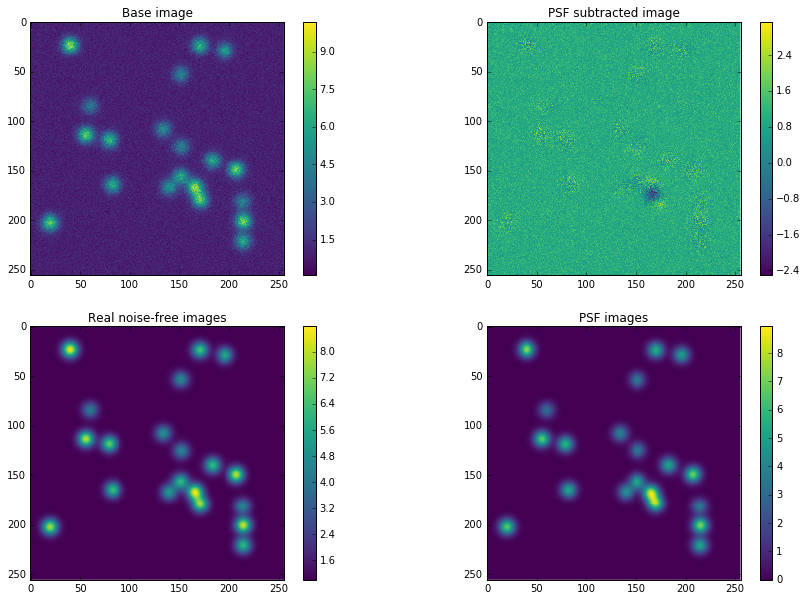

In [19]:
subimi = psf.subtract_psf(pimi, psf_guess, outtabi)
compare_psf_sub(subimi, pimi, imi)

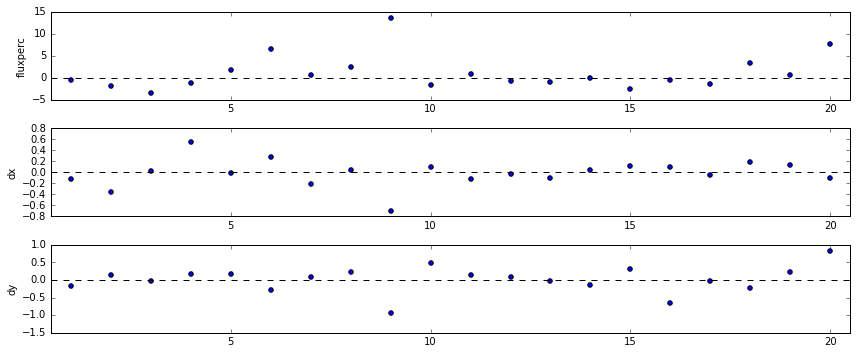

In [20]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And now with a slightly-wrong model (round model, elliptical PSF)

In [21]:
outtab = psf.psf_photometry(pim - bkg, intab, psf_guess, fitshape)
outtab.show_in_notebook()

Subtracted image bkg-sub mean: -0.00417487731843 and SD: 0.317554883321


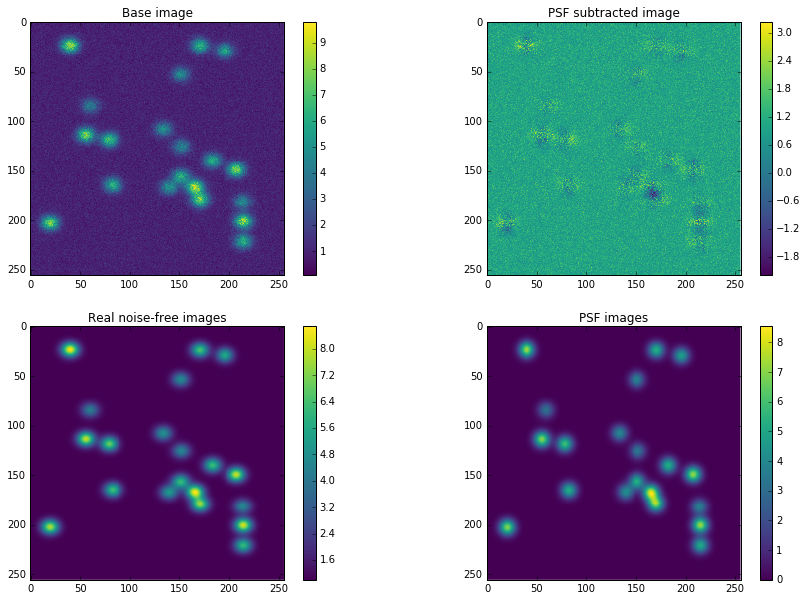

In [22]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

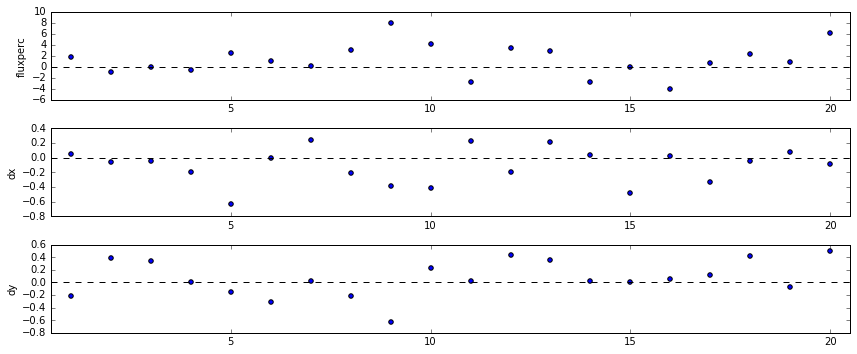

In [23]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)

### Perfect input location, but incorrect flux guess

In [24]:
intab2 = intab['x_0', 'y_0']

As before, start with a well-matched model and PSF

In [25]:
outtabi = psf.psf_photometry(pimi - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: -0.00617683044343 and SD: 0.303749715446


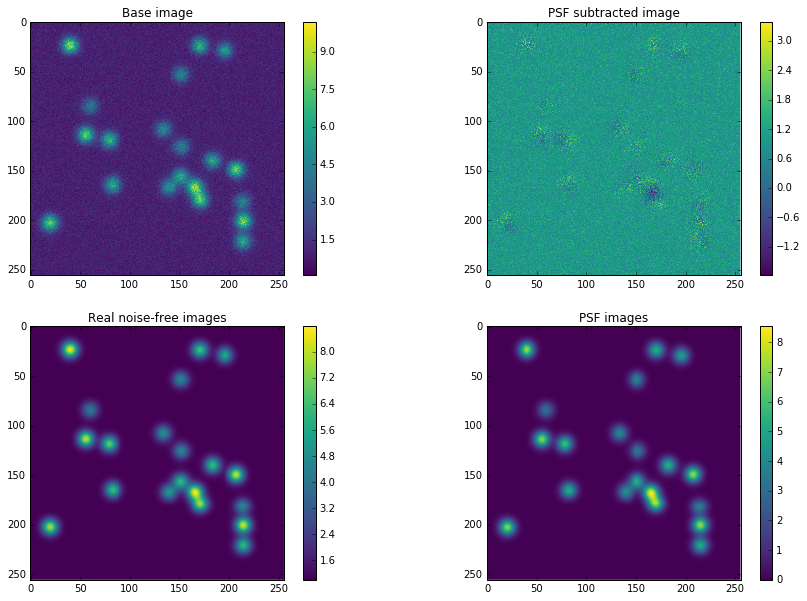

In [26]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

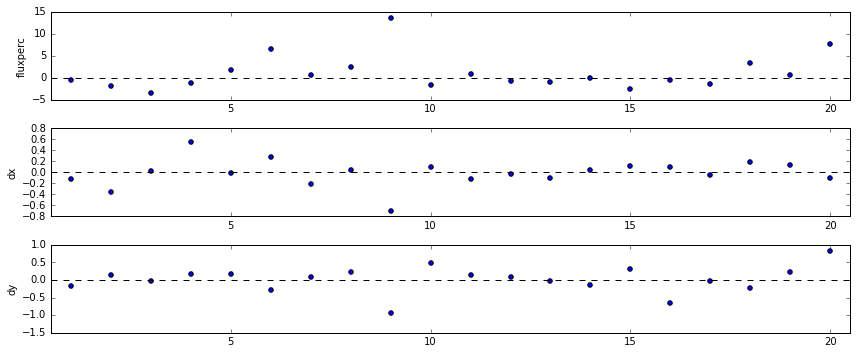

In [27]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And try again with slightly wrong PSF model

In [28]:
outtab = psf.psf_photometry(pim - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

Subtracted image bkg-sub mean: -0.00417493685568 and SD: 0.3175550616


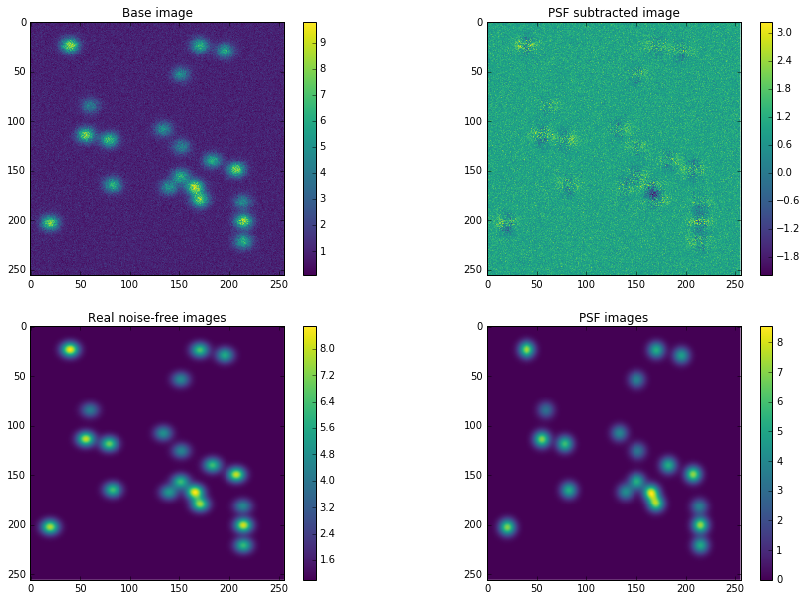

In [29]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

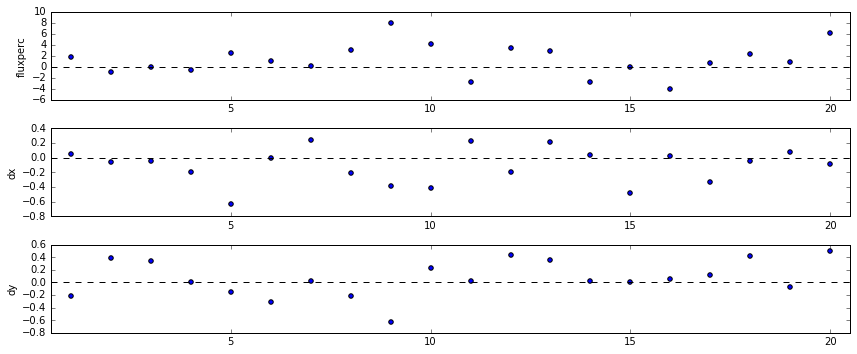

In [30]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)

### Now try with a mocked star-finder that's good but not perfect at the few percent level

In [31]:
x_finder = xs + np.random.randn(*xs.shape)*.1
y_finder = ys + np.random.randn(*ys.shape)*.1
finder_flux = fluxes + np.random.randn(*fluxes.shape)*fluxes/25

# percent error in the flux guesses
(finder_flux-fluxes)*100/fluxes

array([-6.89071876,  1.10678447,  3.59854089, -4.66810065,  0.27293107,
       -1.41758757, -1.39417015,  2.99816428,  5.7940206 , -0.91651132,
        4.48845598,  2.08642201,  2.21436865, -0.16615826, -1.1601513 ,
        0.1372935 , -4.60468208,  3.6029112 , -3.78363034, -7.49292148])

In [32]:
intab3 = Table(names=['x_0', 'y_0', 'flux_0'], data=[x_finder, y_finder, finder_flux])

Again, we start with the matched PSF model

In [33]:
outtabi = psf.psf_photometry(pimi - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_input'] = intab3['flux_0']
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: -0.00617688998068 and SD: 0.303749923703


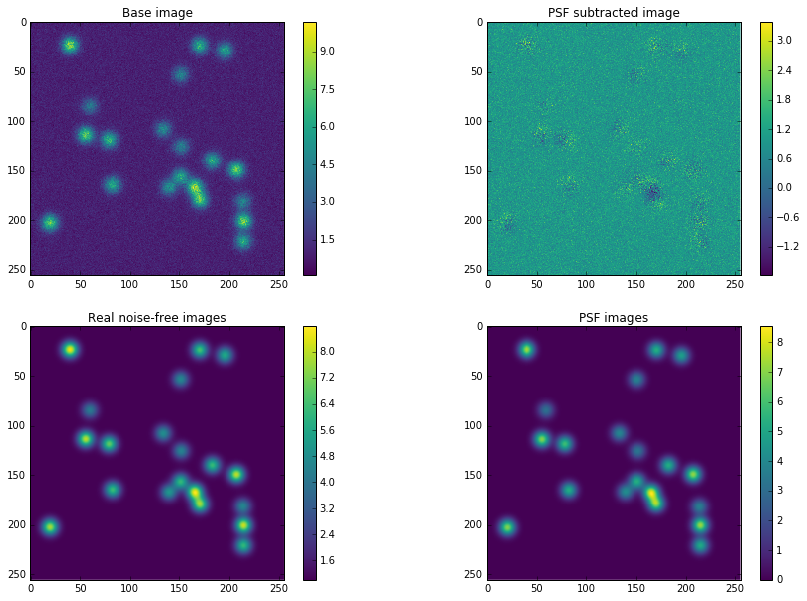

In [34]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

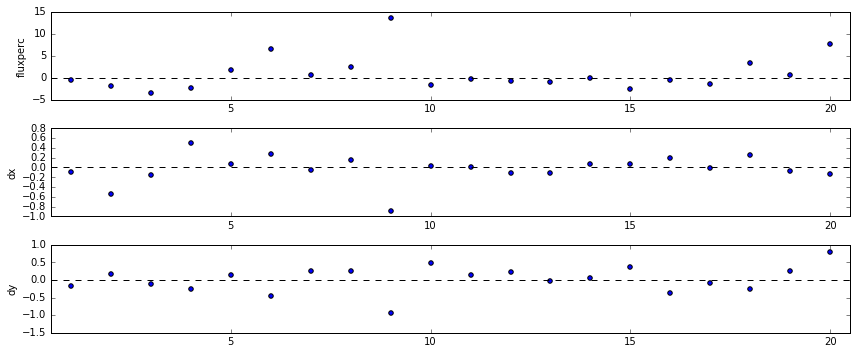

In [35]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi)

And then try again with the mis-matched set

In [36]:
outtab = psf.psf_photometry(pim - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtab['flux_input'] = intab3['flux_0']
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

Subtracted image bkg-sub mean: -0.00424036438431 and SD: 0.317543558702


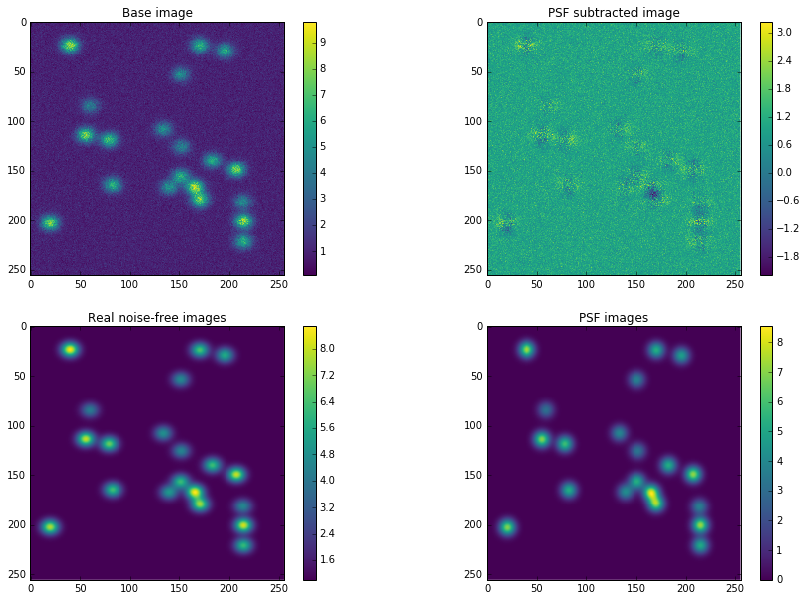

In [37]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

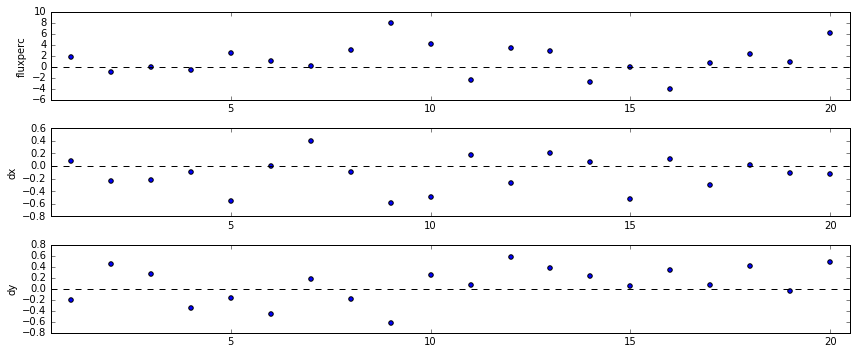

In [38]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab)